# 3D

In [1]:
import numpy             as np
import matplotlib.pyplot as plt
import scipy.sparse      as spa

import hylife.utilitis_FEEC.bsplines     as bsp
import hylife.utilitis_FEEC.Bspline      as bspline 
import hylife.utilitis_FEEC.spline_space as spl
import hylife.utilitis_FEEC.derivatives  as der

import hylife.utilitis_FEEC.basics.mass_matrices_3d  as mass_3d
import hylife.utilitis_FEEC.basics.inner_products_3d as inner_3d
import hylife.utilitis_FEEC.basics.l2_error_3d       as l2_3d

import hylife.utilitis_FEEC.projectors.projectors_local     as proj_local
import hylife.utilitis_FEEC.projectors.projectors_local_mhd as proj_mhd

import hylife.utilitis_FEEC.control_variate as cv
import hylife.geometry.mappings_analytical as mapping

In [58]:
Nel        = [12, 14, 16]            # mesh generation on logical domain
bc         = [False, False, False]     # boundary conditions (True: periodic, False: else)
p          = [2, 2, 2]              # spline degrees  

el_b       = [np.linspace(0., 1., Nel + 1) for Nel in Nel]                      # element boundaries
T          = [bsp.make_knots(el_b, p, bc) for el_b, p, bc in zip(el_b, p, bc)]  # knot vectors (for N functions)

n_quad     = [1, 1, 1]   # number of quadrature points

spaces       = [spl.spline_space_1d(T, p, bc, n_quad) for T, p, bc, n_quad in zip(T, p, bc, n_quad)] # 1d finite element spaces
tensor_space = spl.tensor_spline_space(spaces)                                      # 3d tensor product space

proj_loc   = proj_local.projectors_local_3d(tensor_space, n_quad)

kind_map   = 2
params_map = [2*np.pi/0.75, 1., 0.05, 1.]
#params_map = [2*np.pi/0.75, 1., 1.]

xiplot     = np.linspace(0., 1., 200), np.linspace(0., 1., 100), np.array([0.3])

N          = [bspline.Bspline(spl.T, spl.p)     for spl in spaces]
D          = [bspline.Bspline(spl.t, spl.p - 1) for spl in spaces]

Ntot = spaces[0].NbaseN * spaces[1].NbaseN * spaces[2].NbaseN

In [59]:
xx = np.empty((el_b[0].size, el_b[1].size, el_b[2].size), dtype=float, order='F')
yy = np.empty((el_b[0].size, el_b[1].size, el_b[2].size), dtype=float, order='F')
zz = np.empty((el_b[0].size, el_b[1].size, el_b[2].size), dtype=float, order='F')

In [60]:
mapping.kernel_eva([el_b[0].size, el_b[1].size, el_b[2].size], el_b[0], el_b[1], el_b[2], xx, 1, kind_map, params_map)
mapping.kernel_eva([el_b[0].size, el_b[1].size, el_b[2].size], el_b[0], el_b[1], el_b[2], yy, 2, kind_map, params_map)

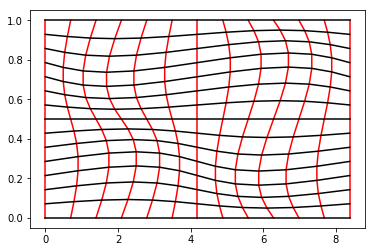

In [61]:
for i in range(len(el_b[0])):
    plt.plot(xx[i, :, 0], yy[i, :, 0], 'r')
    
for i in range(len(el_b[1])):
    plt.plot(xx[:, i, 0], yy[:, i, 0], 'k')

In [55]:
# check if we get correct internal energy
Lx = params_map[0]
Ly = params_map[1]
Lz = params_map[3]

pressure_phys = lambda x, y, z : x*y*z/(Lx*Ly*Lz)*(1 - x/Lx)*(1 - y/Ly)*(1 - z/Lz)
pressure = lambda xi1, xi2, xi3 : xi1*xi2*xi3*(1 - xi1)*(1 - xi2)*(1 - xi3)

pr = proj_loc.pi_0(pressure)
norm = inner_3d.inner_prod_V0(tensor_space, kind_map, params_map, lambda xi1, xi2, xi3 : np.ones(xi1.shape)).flatten()

In [64]:
curl = der.discrete_derivatives(tensor_space).curl_3d()

In [65]:
curl

<10616x11332 sparse matrix of type '<class 'numpy.float64'>'
	with 42464 stored elements in Compressed Sparse Column format>

In [57]:
from scipy import integrate

print(integrate.nquad(pressure_phys, [[0., Lx], [0., Ly], [0., Lz]]))

(0.03878509448876287, 9.688523605579532e-16)


In [10]:
M1 = mass_3d.mass_V1(tensor_space, kind_map, params_map)

In [11]:
test = cv.terms_control_variate(tensor_space, kind_map, params_map)

In [12]:
b_coeff = proj_loc.pi_2([None, None, None], [5, 6, 7], kind_map, params_map)
u_coeff = proj_loc.pi_1([lambda xi1, xi2, xi3 : np.zeros(xi1.shape), lambda xi1, xi2, xi3 : np.cos(2*np.pi*xi1), lambda xi1, xi2, xi3 : np.zeros(xi1.shape)])

In [13]:
mat1 = test.inner_prod_V1_jh_eq(b_coeff)
mat2 = test.mass_V1_nh_eq(b_coeff)

In [14]:
coeff1 = spa.linalg.spsolve(M1, np.concatenate((mat1[0].flatten(), mat1[1].flatten(), mat1[2].flatten())))
coeff2 = spa.linalg.spsolve(M1, -mat2.dot(np.concatenate((u_coeff[0].flatten(), u_coeff[1].flatten(), u_coeff[2].flatten()))))

In [15]:
a1 = tensor_space.evaluate_1form_3d([coeff1[0*Ntot:1*Ntot], coeff1[1*Ntot:2*Ntot], coeff1[2*Ntot:3*Ntot]], xiplot, 1)
a2 = tensor_space.evaluate_1form_3d([coeff1[0*Ntot:1*Ntot], coeff1[1*Ntot:2*Ntot], coeff1[2*Ntot:3*Ntot]], xiplot, 2)
a3 = tensor_space.evaluate_1form_3d([coeff1[0*Ntot:1*Ntot], coeff1[1*Ntot:2*Ntot], coeff1[2*Ntot:3*Ntot]], xiplot, 3)

In [16]:
c1 = tensor_space.evaluate_1form_3d([coeff2[0*Ntot:1*Ntot], coeff2[1*Ntot:2*Ntot], coeff2[2*Ntot:3*Ntot]], xiplot, 1)
c2 = tensor_space.evaluate_1form_3d([coeff2[0*Ntot:1*Ntot], coeff2[1*Ntot:2*Ntot], coeff2[2*Ntot:3*Ntot]], xiplot, 2)
c3 = tensor_space.evaluate_1form_3d([coeff2[0*Ntot:1*Ntot], coeff2[1*Ntot:2*Ntot], coeff2[2*Ntot:3*Ntot]], xiplot, 3)

In [6]:
pro_mhd = proj_mhd.projectors_local_mhd(tensor_space, n_quad)
pro_mhd_old = proj_mhd_old.projectors_local_mhd(T, p, bc)

In [7]:
K = pro_mhd.projection_K(kind_map, params_map)

In [8]:
K_old = pro_mhd_old.projection_K(kind_map, params_map)

In [9]:
np.allclose(K.toarray(), K_old.toarray())

True

In [7]:
spaces = [spl.spline_space_1d(T, p, bc, p + 1) for T, p, bc in zip(T, p, bc)]

In [8]:
tensor_space = spl.tensor_spline_space(spaces)

In [9]:
M_new = mass_3d.mass_V0(tensor_space, kind_map, params_map)

In [30]:
np.allclose(M_old.toarray(), M_new.toarray())

True

In [10]:
fun = lambda xi1, xi2, xi3 : np.sin(np.sin(2*np.pi*xi1) * np.sin(2*np.pi*xi2) * np.sin(2*np.pi*xi3))

In [58]:
F_old = mass_old.inner_prod_V0_3d(T, p, bc, fun, None, kind_map, params_map)

In [11]:
F_new = inner_3d.inner_prod_V0(tensor_space, kind_map, params_map, fun)

In [60]:
np.allclose(F_old, F_new)

True

In [12]:
coeff = sparse.linalg.spsolve(M_new, F_new.flatten()).reshape(NbaseN[0], NbaseN[1], NbaseN[2])

In [13]:
err0 = l2_3d.l2_error_V0(tensor_space, kind_map, params_map, coeff, fun)

In [14]:
test = tensor_space.evaluate_0form_3d(coeff, xiplot)

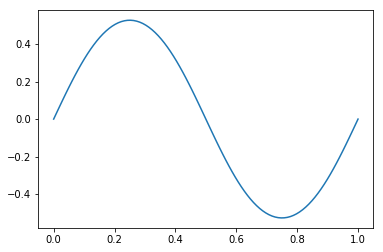

In [17]:
plt.plot(xiplot[0], test[:, 10, 0])

In [61]:
test.l2_error_V0(coeff, fun)

0.013757541904854434

In [62]:
err0

0.013757541904854434

In [31]:
fun1 = lambda xi1, xi2, xi3 : np.sin(np.cos(2*np.pi*xi1) * np.sin(2*np.pi*xi2) * np.sin(2*np.pi*xi3))
fun2 = lambda xi1, xi2, xi3 : np.sin(np.cos(2*np.pi*xi1) * np.cos(2*np.pi*xi2) * np.sin(2*np.pi*xi3))
fun3 = lambda xi1, xi2, xi3 : np.sin(np.cos(2*np.pi*xi1) * np.sin(2*np.pi*xi2) * np.cos(2*np.pi*xi3))

In [32]:
F_new = inner.inner_prod_V1(tensor_space, kind_map, params_map, [fun1, fun2, fun3])

In [19]:
pr_loc = proj_local.projectors_local_3d(T, p, bc)
err    = l2error.l2_errors_3d(T, p, bc, [p[0] + 1, p[1] + 1, p[2] + 1], kind_map, params_map)

In [20]:
import hylife.interface as inter

In [21]:
xi1 = 0.2
xi2 = 0.4
xi3 = 0.6

value = (mapping.df(xi1, xi2, xi3, kind_map, params_map, 11) * inter.b1_eq(xi1, xi2, xi3, kind_map, params_map) + mapping.df(xi1, xi2, xi3, kind_map, params_map, 12) * inter.b2_eq(xi1, xi2, xi3, kind_map, params_map))/mapping.det_df(xi1, xi2, xi3, kind_map, params_map)

In [22]:
value

1.0

In [23]:
f2_h = fem._2form(T, p, bc, pr_loc.PI_2([None, None, None], [5, 6, 7], kind_map, params_map))

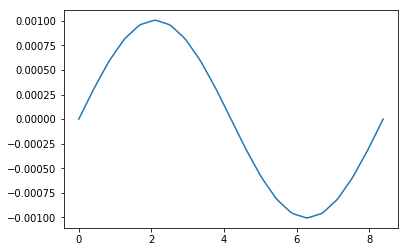

In [24]:
xx = np.empty((xiplot[0].size, xiplot[1].size, xiplot[2].size), dtype=float, order='F')
mapping.kernel_eva([xiplot[0].size, xiplot[1].size, xiplot[2].size], xiplot[0], xiplot[1], xiplot[2], xx, 1, kind_map, params_map)

det_df = np.empty((xiplot[0].size, xiplot[1].size, xiplot[2].size), dtype=float, order='F')
mapping.kernel_eva([xiplot[0].size, xiplot[1].size, xiplot[2].size], xiplot[0], xiplot[1], xiplot[2], det_df, 4, kind_map, params_map)

plt.plot(xx[:, 0, 0], f2_h.evaluate_3component(xiplot)[:, 0, 0]/det_df[:, 0, 0])

In [10]:
f0     = lambda xi1, xi2, xi3 : np.sin(np.sin(2*np.pi*xi1) * np.sin(2*np.pi*xi2) * np.sin(2*np.pi*xi3))

coeff0 = proj_loc.pi_0(f0)

print('error : ', l2_3d.l2_error_V0(tensor_space, 1, [1., 1., 1.], coeff0, f0))

error :  0.0005102871256935877


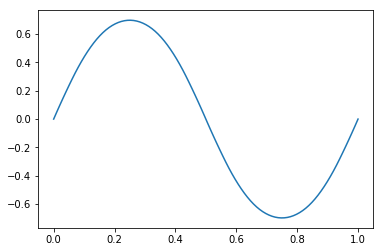

In [11]:
plt.plot(xiplot[1], tensor_space.evaluate_0form_3d(coeff0, xiplot)[30, :, 0])

In [12]:
f1_1 = lambda xi1, xi2, xi3 : np.cos(2*np.pi*xi1) * np.sin(2*np.pi*xi2) * np.sin(2*np.pi*xi3) * 2*np.pi
f1_2 = lambda xi1, xi2, xi3 : np.sin(2*np.pi*xi1) * np.cos(2*np.pi*xi2) * np.sin(2*np.pi*xi3) * 2*np.pi
f1_3 = lambda xi1, xi2, xi3 : np.sin(2*np.pi*xi1) * np.sin(2*np.pi*xi2) * np.cos(2*np.pi*xi3) * 2*np.pi

In [13]:
coeff1 = proj_loc.pi_1([f1_1, f1_2, f1_3])

print('error : ', l2_3d.l2_error_V1(tensor_space, 1, [1., 1., 1.], coeff1, [f1_1, f1_2, f1_3]))

error :  0.0228009209101833


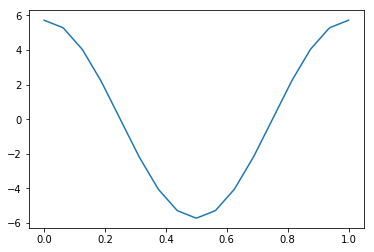

In [14]:
plt.plot(xiplot[0], tensor_space.evaluate_1form_3d(coeff1, xiplot, 1)[:, 30, 0])

In [43]:
f2_1 = lambda xi1, xi2, xi3 : np.sin(2*np.pi*xi1) * np.cos(2*np.pi*xi2) * np.cos(2*np.pi*xi3) * (2*np.pi)**2
f2_2 = lambda xi1, xi2, xi3 : np.cos(2*np.pi*xi1) * np.sin(2*np.pi*xi2) * np.cos(2*np.pi*xi3) * (2*np.pi)**2
f2_3 = lambda xi1, xi2, xi3 : np.cos(2*np.pi*xi1) * np.cos(2*np.pi*xi2) * np.sin(2*np.pi*xi3) * (2*np.pi)**2

In [44]:
coeff2 = proj_loc.pi_2([f2_1, f2_2, f2_3])

print('error : ', l2_3d.l2_error_V2(tensor_space, 1, [1., 1., 1.], coeff2, [f2_1, f2_2, f2_3]))

error :  0.2010940157567911


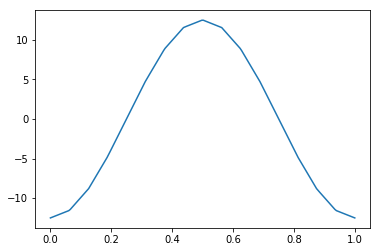

In [45]:
plt.plot(xiplot[0], tensor_space.evaluate_2form_3d(coeff2, xiplot, 3)[:, 30, 0])

In [46]:
f3     = lambda xi1, xi2, xi3 : np.sin(np.sin(2*np.pi*xi1) * np.sin(2*np.pi*xi2) * np.sin(2*np.pi*xi3))

coeff3 = proj_loc.pi_3(f3)

print('error : ', l2_3d.l2_error_V3(tensor_space, 1, [1., 1., 1.], coeff3, f3))

error :  0.003467679158849669


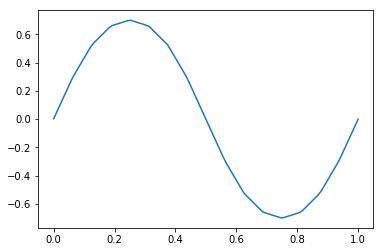

In [47]:
plt.plot(xiplot[1], tensor_space.evaluate_3form_3d(coeff3, xiplot)[30, :, 0])

In [19]:
deriv = der.discrete_derivatives(tensor_space)

GRAD = deriv.grad_3d()
CURL = deriv.curl_3d()
DIV  = deriv.div_3d()

In [20]:
# commutativity V0, V1?
test_fun  = lambda x, y, z : np.sin(2*np.pi*x)*np.sin(2*np.pi*y)*np.sin(2*np.pi*z)

test_fun1 = lambda x, y, z : np.cos(2*np.pi*x)*np.sin(2*np.pi*y)*np.sin(2*np.pi*z)*2*np.pi
test_fun2 = lambda x, y, z : np.sin(2*np.pi*x)*np.cos(2*np.pi*y)*np.sin(2*np.pi*z)*2*np.pi
test_fun3 = lambda x, y, z : np.sin(2*np.pi*x)*np.sin(2*np.pi*y)*np.cos(2*np.pi*z)*2*np.pi

lhs = GRAD.dot(proj_loc.pi_0(test_fun).flatten())

rhs = proj_loc.pi_1([test_fun1, test_fun2, test_fun3])
rhs = np.concatenate((rhs[0].flatten(), rhs[1].flatten(), rhs[2].flatten()))

print(np.abs(rhs - lhs).max())

2.4980018054066022e-15


In [21]:
# commutativity V1, V2?
test_fun1  = lambda x, y, z : np.sin(2*np.pi*x)*np.sin(2*np.pi*y)*np.sin(2*np.pi*z)
test_fun2  = lambda x, y, z : np.sin(2*np.pi*x)*np.sin(2*np.pi*y)*np.sin(2*np.pi*z)
test_fun3  = lambda x, y, z : np.sin(2*np.pi*x)*np.sin(2*np.pi*y)*np.sin(2*np.pi*z)

test_fun1d = lambda x, y, z : np.sin(2*np.pi*x)*np.cos(2*np.pi*y)*np.sin(2*np.pi*z)*2*np.pi - np.sin(2*np.pi*x)*np.sin(2*np.pi*y)*np.cos(2*np.pi*z)*2*np.pi
test_fun2d = lambda x, y, z : np.sin(2*np.pi*x)*np.sin(2*np.pi*y)*np.cos(2*np.pi*z)*2*np.pi - np.cos(2*np.pi*x)*np.sin(2*np.pi*y)*np.sin(2*np.pi*z)*2*np.pi
test_fun3d = lambda x, y, z : np.cos(2*np.pi*x)*np.sin(2*np.pi*y)*np.sin(2*np.pi*z)*2*np.pi - np.sin(2*np.pi*x)*np.cos(2*np.pi*y)*np.sin(2*np.pi*z)*2*np.pi

lhs = proj_loc.pi_1([test_fun1, test_fun2, test_fun3])
lhs = CURL.dot(np.concatenate((lhs[0].flatten(), lhs[1].flatten(), lhs[2].flatten())))

rhs = proj_loc.pi_2([test_fun1d, test_fun2d, test_fun3d])
rhs = np.concatenate((rhs[0].flatten(), rhs[1].flatten(), rhs[2].flatten()))

print(np.abs(rhs - lhs).max())

2.445960101127298e-16


In [22]:
# commutativity V2, V3?
test_fun1  = lambda x, y, z : np.sin(2*np.pi*x)*np.sin(2*np.pi*y)*np.sin(2*np.pi*z)
test_fun2  = lambda x, y, z : np.sin(2*np.pi*x)*np.sin(2*np.pi*y)*np.sin(2*np.pi*z)
test_fun3  = lambda x, y, z : np.sin(2*np.pi*x)*np.sin(2*np.pi*y)*np.sin(2*np.pi*z)

test_fun   = lambda x, y, z : np.cos(2*np.pi*x)*np.sin(2*np.pi*y)*np.sin(2*np.pi*z)*2*np.pi + np.sin(2*np.pi*x)*np.cos(2*np.pi*y)*np.sin(2*np.pi*z)*2*np.pi + np.sin(2*np.pi*x)*np.sin(2*np.pi*y)*np.cos(2*np.pi*z)*2*np.pi

lhs = proj_loc.pi_2([test_fun1, test_fun2, test_fun3])
lhs = DIV.dot(np.concatenate((lhs[0].flatten(), lhs[1].flatten(), lhs[2].flatten())))

rhs = proj_loc.pi_3(test_fun).flatten()

print(np.abs(rhs - lhs).max())

1.474514954580286e-17


In [20]:
grad

array([[-1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0., -1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0., -1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -1.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0., -1.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -1.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  1.]])

In [3]:
test = proj_new.projectors_3d(T, p, bc)
test_old = proj.projectors_3d(p, Nbase_old, T, bc)

In [4]:
test.assemble_V0()
test.assemble_V1()
test.assemble_V2()
test.assemble_V3()

test_old.assemble_V0()
test_old.assemble_V1()
test_old.assemble_V2()
test_old.assemble_V3()

In [5]:
a0       = lambda xi1, xi2, xi3 : np.sin(2*np.pi*xi1)*np.sin(2*np.pi*xi2)*np.sin(2*np.pi*xi3)

vec0     = test.PI_0(a0)
vec0_old = test_old.PI_0(a0)

In [6]:
np.allclose(vec0, vec0_old.reshape(NbaseN[0], NbaseN[1], NbaseN[2]))

True

In [7]:
a1       = [lambda xi1, xi2, xi3 : np.cos(2*np.pi*xi1)*np.sin(2*np.pi*xi2)*np.sin(2*np.pi*xi3), lambda xi1, xi2, xi3 : np.sin(2*np.pi*xi1)*np.cos(2*np.pi*xi2)*np.sin(2*np.pi*xi3), lambda xi1, xi2, xi3 : np.sin(2*np.pi*xi1)*np.sin(2*np.pi*xi2)*np.cos(2*np.pi*xi3)]
vec1     = test.PI_1(a1)
vec1_old = test_old.PI_1(a1)

In [8]:
print(np.allclose(vec1[0], vec1_old[0].reshape(NbaseD[0], NbaseN[1], NbaseN[2])))
print(np.allclose(vec1[1], vec1_old[1].reshape(NbaseN[0], NbaseD[1], NbaseN[2])))
print(np.allclose(vec1[2], vec1_old[2].reshape(NbaseN[0], NbaseN[1], NbaseD[2])))

True
True
True


In [9]:
a2       = [lambda xi1, xi2, xi3 : np.sin(2*np.pi*xi1)*np.cos(2*np.pi*xi2)*np.cos(2*np.pi*xi3), lambda xi1, xi2, xi3 : np.cos(2*np.pi*xi1)*np.sin(2*np.pi*xi2)*np.cos(2*np.pi*xi3), lambda xi1, xi2, xi3 : np.cos(2*np.pi*xi1)*np.cos(2*np.pi*xi2)*np.sin(2*np.pi*xi3)]
vec2     = test.PI_2(a2)
vec2_old = test_old.PI_2(a2)

In [10]:
print(np.allclose(vec2[0], vec2_old[0].reshape(NbaseN[0], NbaseD[1], NbaseD[2])))
print(np.allclose(vec2[1], vec2_old[1].reshape(NbaseD[0], NbaseN[1], NbaseD[2])))
print(np.allclose(vec2[2], vec2_old[2].reshape(NbaseD[0], NbaseD[1], NbaseN[2])))

True
True
True


In [11]:
a3       = lambda xi1, xi2, xi3 : np.cos(2*np.pi*xi1)*np.cos(2*np.pi*xi2)*np.cos(2*np.pi*xi3)
vec3     = test.PI_3(a3)
vec3_old = test_old.PI_3(a3)

In [12]:
np.allclose(vec3, vec3_old.reshape(NbaseD[0], NbaseD[1], NbaseD[2]))

True

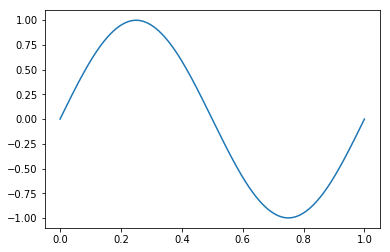

In [13]:
xplot = np.linspace(0., 1., 500)
res   = eva.FEM_field_V0_3d(vec0, [xplot, np.array([0.25]), np.array([0.25])], T, p, bc)
plt.plot(xplot, res[:, 0, 0])

# 1D

In [1]:
import numpy             as np
import matplotlib.pyplot as plt
import scipy.sparse      as spa

import hylife.utilitis_FEEC.bsplines     as bsp
import hylife.utilitis_FEEC.Bspline      as bspline 
import hylife.utilitis_FEEC.spline_space as spl
import hylife.utilitis_FEEC.derivatives  as der

import hylife.utilitis_FEEC.basics.mass_matrices_1d  as mass_1d
import hylife.utilitis_FEEC.basics.inner_products_1d as inner_1d
import hylife.utilitis_FEEC.basics.l2_error_1d       as l2_1d

import hylife.utilitis_FEEC.projectors.projectors_local as proj_local

In [2]:
Nel    = 6                                    # number of elements   
bc     = True                                 # boundary conditions (True: periodic, False: else)
p      = 1                                    # spline degres  
n_quad = p + 2                                # number of quadrature points per integration interval

el_b   = np.linspace(0., 1., Nel + 1)         # element boundaries
T      = bsp.make_knots(el_b, p, bc)          # knot vector


space    = spl.spline_space_1d(T, p, bc, n_quad) # finite element space

proj_loc = proj_local.projectors_local_1d(space, n_quad)  # local projectors

N = bspline.Bspline(space.T, space.p)
D = bspline.Bspline(space.t, space.p - 1)

xiplot = np.linspace(0., 1., 200)

Text(0.5,1,'D')

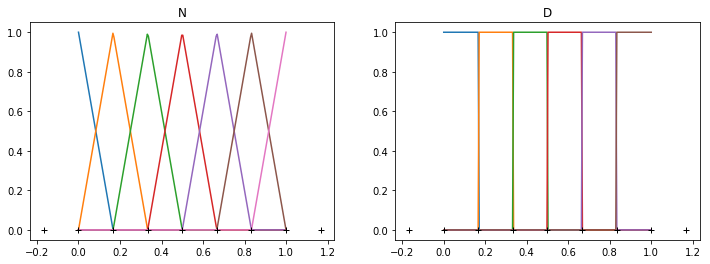

In [3]:
fig = plt.figure()
fig.set_figwidth(12)

plt.subplot(1, 2, 1)

for i in range(N.N):
    plt.plot(xiplot, N(xiplot, i))
    
plt.plot(T, np.zeros(len(T)), 'k+')

#plt.plot(proj_loc.x_int[3], np.zeros(5), 'r+')
plt.title('N')



plt.subplot(1, 2, 2)

for i in range(D.N):
    plt.plot(xiplot, D(xiplot, i))
    
plt.plot(T, np.zeros(len(T)), 'k+')
plt.title('D')

In [65]:
mapping     = lambda xi : 2*np.pi*xi
mapping_der = lambda xi : 2*np.pi*np.ones(xi.shape)

fun_phys = lambda x : np.exp(np.sin(x))

def fun_0(xi):
    x = mapping(xi)
    return fun_phys(x)

def fun_1(xi):
    x = mapping(xi)
    return fun_phys(x)*mapping_der(xi)

In [66]:
# test L2 - projection
M0 = mass_1d.mass_V0(space, mapping_der)
M1 = mass_1d.mass_V1(space, mapping_der)

f0 = inner_1d.inner_prod_V0(space, mapping_der, fun_0)
f1 = inner_1d.inner_prod_V1(space, mapping_der, fun_1)

coeff0 = spa.linalg.spsolve(M0, f0)
coeff1 = spa.linalg.spsolve(M1, f1)

In [67]:
res0 = space.evaluate_0form(coeff0, xiplot)
res1 = space.evaluate_1form(coeff1, xiplot)

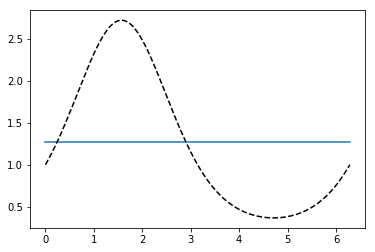

In [68]:
plt.plot(mapping(xiplot), res0)
plt.plot(mapping(xiplot), fun_phys(mapping(xiplot)), 'k--')

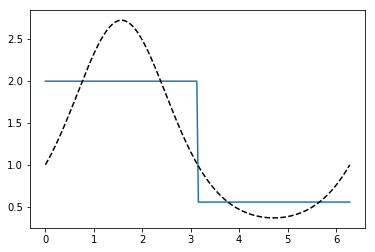

In [69]:
plt.plot(mapping(xiplot), res1/mapping_der(xiplot))
plt.plot(mapping(xiplot), fun_phys(mapping(xiplot)), 'k--')

In [70]:
# test local projector
coeff0 = proj_loc.pi_0(fun_0)
coeff1 = proj_loc.pi_1(fun_1)

In [71]:
res0 = space.evaluate_0form(coeff0, xiplot)
res1 = space.evaluate_1form(coeff1, xiplot)

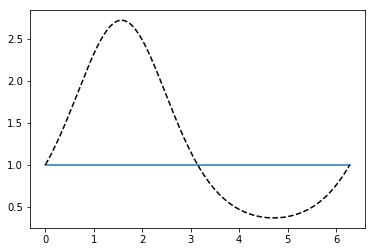

In [72]:
plt.plot(mapping(xiplot), res0)
plt.plot(mapping(xiplot), fun_phys(mapping(xiplot)), 'k--')

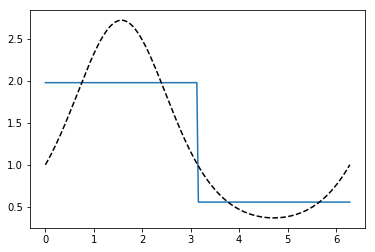

In [73]:
plt.plot(mapping(xiplot), res1/mapping_der(xiplot))
plt.plot(mapping(xiplot), fun_phys(mapping(xiplot)), 'k--')

In [74]:
# l2 errors
err0 = l2_1d.l2_error_V0(space, mapping_der, coeff0, fun_0)
err1 = l2_1d.l2_error_V1(space, mapping_der, coeff1, fun_1)

print(err0)
print(err1)

0.903578217970971
2.975377396346046


In [75]:
t = space.t
NbaseN = space.NbaseN
NbaseD = space.NbaseD

In [76]:
# global assembly of projection matrix PI_0(D)
basis = bsp.collocation_matrix(t, p - 1, proj_loc.x_int.flatten(), bc)
tau_glob = np.zeros((NbaseD, NbaseN))

for i in range(NbaseD):
    
    if bc == False:
        fun = lambda x : D(x, i) * np.cos(2*np.pi*x)
    else:
        if i < p - 1:
            fun = lambda x : (D(x, i) + D(x, NbaseD + i)) * np.cos(2*np.pi*x)
        else:
            fun = lambda x : D(x, i) * np.cos(2*np.pi*x)
            
    tau_glob[i, :] = proj_loc.pi_0(fun)

In [77]:
# local assembly of projection matrix PI_0(D)

# non-vanishing coefficients (# basis functions (bf) of sntp,  maximum # of non-vanishing coefficients for each bf)
tau_loc = np.zeros((NbaseD, proj_loc.n_int_nvcof_D))

# evaluation of sntp at interpolation points
x_int = np.unique(proj_loc.x_int.flatten())
basis = bsp.collocation_matrix(t, p - 1, x_int, bc)

# loop over coefficients
for i in range(NbaseN):
    
    # loop over interpolation points
    for j in range(proj_loc.n_int):
        
        # loop over non-vanishing bf
        for kl in range(proj_loc.n_int_locbf_D):
            k      = proj_loc.int_global_D[i, kl]     # global index of bf 
            c_loc  = proj_loc.int_loccof_D[i, kl]     # local index of non-vanishing coefficients for this bf
            
            tau_loc[k, c_loc] += proj_loc.coeff_i[proj_loc.coeffi_indices[i], j] * basis[proj_loc.x_int_indices[i, j], k] * np.cos(2*np.pi*x_int[proj_loc.x_int_indices[i, j]])
            
            
# global indices in final matrix
indices = np.indices((NbaseD, proj_loc.n_int_nvcof_D))

# row indices
row = indices[0]

# column indices
col = (indices[1] + proj_loc.int_shift_D[:, None])%NbaseN

# build matrix
tau_loc = spa.csr_matrix((tau_loc.flatten(), (row.flatten(), col.flatten())), shape=(NbaseD, NbaseN))

In [78]:
np.allclose(tau_loc.toarray(), tau_glob)

True

In [79]:
# global assembly of projection matrix PI_0(N)
basis = bsp.collocation_matrix(T, p, proj_loc.x_int.flatten(), bc)
tau_glob = np.zeros((NbaseN, NbaseN))

for i in range(NbaseN):
    
    if bc == False:
        fun = lambda x : N(x, i) * np.cos(2*np.pi*x)
    else:
        if i < p:
            fun = lambda x : (N(x, i) + N(x, NbaseN + i)) * np.cos(2*np.pi*x)
        else:
            fun = lambda x : N(x, i) * np.cos(2*np.pi*x)
            
    tau_glob[i, :] = proj_loc.pi_0(fun)

In [80]:
# local assembly of projection matrix PI_0(N)

# non-vanishing coefficients (# basis functions (bf) of sntp,  maximum # of non-vanishing coefficients for each bf)
tau_loc = np.zeros((NbaseN, proj_loc.n_int_nvcof_N))

# evaluation of sntp at interpolation points
x_int = np.unique(proj_loc.x_int.flatten())
basis = bsp.collocation_matrix(T, p, x_int, bc)


# loop over coefficients
for i in range(NbaseN):
    
    # loop over interpolation points
    for j in range(proj_loc.n_int):
        
        # loop over non-vanishing bf
        for kl in range(proj_loc.n_int_locbf_N):
            k      = proj_loc.int_global_N[i, kl]    # global index of bf 
            c_loc  = proj_loc.int_loccof_N[i, kl]    # local index of non-vanishing coefficients for this bf
            
            tau_loc[k, c_loc] += proj_loc.coeff_i[proj_loc.coeffi_indices[i], j] * basis[proj_loc.x_int_indices[i, j], k] * np.cos(2*np.pi*x_int[proj_loc.x_int_indices[i, j]])
            

# global indices in final matrix
indices = np.indices((NbaseN, proj_loc.n_int_nvcof_N))

# row indices
row = indices[0]

# column indices
col = (indices[1] + proj_loc.int_shift_N[:, None])%NbaseN

# build matrix
tau_loc = spa.csr_matrix((tau_loc.flatten(), (row.flatten(), col.flatten())), shape=(NbaseN, NbaseN))

In [81]:
np.allclose(tau_glob, tau_loc.toarray())

True

In [82]:
# global assembly of projection matrix PI_1(D)
tau_glob = np.zeros((NbaseD, NbaseD))

for i in range(NbaseD):
    
    if bc == False:
        fun = lambda x : D(x, i) * np.cos(2*np.pi*x)
    else:
        if i < p - 1:
            fun = lambda x : (D(x, i) + D(x, NbaseD + i)) * np.cos(2*np.pi*x)
        else:
            fun = lambda x : D(x, i) * np.cos(2*np.pi*x)
            
    tau_glob[i, :] = proj_loc.pi_1(fun)

In [83]:
# local assembly of projection matrix PI_1(D)

# non-vanishing coefficients (# basis functions (bf) of sntp,  maximum # of non-vanishing coefficients for each bf)
tau_loc = np.zeros((NbaseD, proj_loc.n_his_nvcof_D))

# evaluation of sntp at quadrature points
basis = bsp.collocation_matrix(t, p - 1, proj_loc.pts.flatten(), bc).reshape(proj_loc.pts[:, 0].size, proj_loc.pts[0, :].size, NbaseD)


# loop over coefficients
for i in range(NbaseD):
    
    # loop over histopolation intervals
    for j in range(proj_loc.n_his):
        
        # loop over non-vanishing bf
        for kl in range(proj_loc.n_his_locbf_D):
            k      = proj_loc.his_global_D[i, kl]    # global index of bf 
            c_loc  = proj_loc.his_loccof_D[i, kl]    # local index of non-vanishing coefficients for this bf
            
            f_int = 0.
            
            for q in range(proj_loc.n_quad):
                f_int += proj_loc.wts[proj_loc.x_his_indices[i, j], q] * basis[proj_loc.x_his_indices[i, j], q, k] * np.cos(2*np.pi*proj_loc.pts[proj_loc.x_his_indices[i, j], q])
            
            tau_loc[k, c_loc] += proj_loc.coeff_h[proj_loc.coeffh_indices[i], j] * f_int
            
            
# global indices in final matrix
indices = np.indices((NbaseD, proj_loc.n_his_nvcof_D))

# row indices
row = indices[0]

# column indices
col = (indices[1] + proj_loc.his_shift_D[:, None])%NbaseD

# build matrix
tau_loc = spa.csr_matrix((tau_loc.flatten(), (row.flatten(), col.flatten())), shape=(NbaseD, NbaseD))

In [84]:
np.allclose(tau_glob, tau_loc.toarray())

True

In [85]:
# global assembly of projection matrix PI_1(N)
tau_glob = np.zeros((NbaseN, NbaseD))

for i in range(NbaseN):
    
    if bc == False:
        fun = lambda x : N(x, i) * np.cos(2*np.pi*x)
    else: 
        if i < p:
            fun = lambda x : (N(x, i) + N(x, NbaseN + i)) * np.cos(2*np.pi*x)
        else:
            fun = lambda x : N(x, i) * np.cos(2*np.pi*x)
            
    tau_glob[i, :] = proj_loc.pi_1(fun)

In [86]:
# local assembly of projection matrix PI_1(N)

# non-vanishing coefficients (# basis functions (bf) of sntp,  maximum # of non-vanishing coefficients for each bf)
tau_loc = np.zeros((NbaseN, proj_loc.n_his_nvcof_N))

# evaluation of sntp at quadrature points
basis = bsp.collocation_matrix(T, p, proj_loc.pts.flatten(), bc).reshape(proj_loc.pts[:, 0].size, proj_loc.pts[0, :].size, NbaseN)


# loop over coefficients
for i in range(NbaseD):
    
    # loop over histopolation intervals
    for j in range(proj_loc.n_his):
        
        # loop over non-vanishing bf
        for kl in range(proj_loc.n_his_locbf_N):
            k      = proj_loc.his_global_N[i, kl]    # global index of bf 
            c_loc  = proj_loc.his_loccof_N[i, kl]    # local index of non-vanishing coefficients for this bf
            
            f_int = 0.
            
            for q in range(proj_loc.n_quad):
                f_int += proj_loc.wts[proj_loc.x_his_indices[i, j], q] * basis[proj_loc.x_his_indices[i, j], q, k] * np.cos(2*np.pi*proj_loc.pts[proj_loc.x_his_indices[i, j], q])
            
            tau_loc[k, c_loc] += proj_loc.coeff_h[proj_loc.coeffh_indices[i], j] * f_int
            
            
# global indices in final matrix
indices = np.indices((NbaseN, proj_loc.n_his_nvcof_N))

# row indices
row = indices[0]

# column indices
col = (indices[1] + proj_loc.his_shift_N[:, None])%NbaseD

# build matrix
tau_loc = spa.csr_matrix((tau_loc.flatten(), (row.flatten(), col.flatten())), shape=(NbaseN, NbaseD))

In [87]:
np.allclose(tau_loc.toarray(), tau_glob)

True

In [88]:
# L2-projection
rhs = mass.inner_prod_V0_1d(T, p, bc, lambda x : 1., fun)
M0  = mass.mass_1d_NN(T, p, bc)
coeff = np.linalg.solve(M0.toarray(), rhs)

res   = eva.FEM_field_V0_1d(coeff, xplot, T, p, bc)

'''
for i in range(D.N):
    plt.plot(xplot, D(xplot, i))
    
plt.plot(T, np.zeros(len(T)), 'k+')
'''

plt.plot(xplot, res)
plt.plot(xplot, fun(xplot))

NameError: name 'mass' is not defined

In [21]:
coeff

array([ 6.38049938e-06, -1.38304559e-05,  2.02471985e-05, -4.22887196e-05,
        9.61920051e-05, -2.22533346e-04,  5.16454158e-04, -1.19931071e-03,
        2.78577898e-03, -6.48102155e-03,  1.53107718e-02, -4.15635876e-02,
        9.40554975e-01,  2.48057967e-02])

In [163]:
values = np.zeros((7, 7))

i = 4
x = np.array([T[p + i], (T[p + i] + T[p + 1 + i])/2, T[p + 1 + i], (T[p + 1 + i] + T[p + 2 + i])/2, T[p + 2 + i], (T[p + 2 + i] + T[p + 3 + i])/2, T[p + 3 + i]])

for i in range(7):
    for j in range(7):
        
        values[i, j] = N(x[j], i + 4) 
        
45/2*np.linalg.solve(values, np.array([0., 0., 0., 1., 0., 0., 0.]))

array([ -1.  ,  16.  , -73.75, 140.  , -73.75,  16.  ,  -1.  ])

In [177]:
int(3/2 + 1/2)

2

In [48]:
test_fun = lambda x : np.sin(2*np.pi*x)
test_fun_d = lambda x : np.cos(2*np.pi*x)*2*np.pi

In [49]:
coeff = proj_loc.PI_0(test_fun)

In [50]:
coeff

array([-0.57372817, -0.20146654,  0.20146654,  0.57372817,  0.85864488,
        1.0128407 ,  1.0128407 ,  0.85864488,  0.57372817,  0.20146654,
       -0.20146654, -0.57372817, -0.85864488, -1.0128407 , -1.0128407 ,
       -0.85864488])

In [51]:
mass.L2_error_V0_1d(coeff, T, p, bc, test_fun)

5.984051317907733e-06

In [52]:
res = eva.FEM_field_V0_1d(coeff, xplot, T, p, bc)

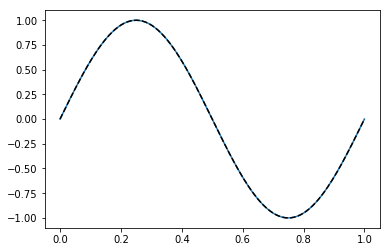

In [53]:
plt.plot(xplot, res)
plt.plot(xplot, test_fun(xplot), 'k--')

In [54]:
coeff = proj_loc.PI_1(test_fun)

In [55]:
res = eva.FEM_field_V1_1d(coeff, xplot, T, p, bc)

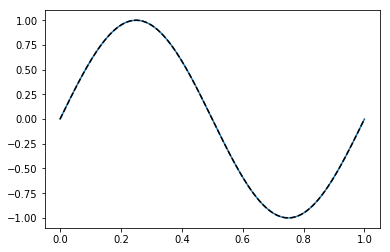

In [56]:
plt.plot(xplot, res)
plt.plot(xplot, test_fun(xplot), 'k--')

In [57]:
# commutativity ?
grad  = der.GRAD_1d(T, p, bc)
coeff = proj_loc.PI_0(test_fun)

lhs = grad.dot(coeff)

rhs = proj_loc.PI_1(test_fun_d)

In [58]:
lhs

array([ 3.72261627e-01,  4.02933082e-01,  3.72261627e-01,  2.84916715e-01,
        1.54195815e-01,  4.44089210e-16, -1.54195815e-01, -2.84916715e-01,
       -3.72261627e-01, -4.02933082e-01, -3.72261627e-01, -2.84916715e-01,
       -1.54195815e-01,  0.00000000e+00,  1.54195815e-01,  2.84916715e-01])

In [59]:
rhs

array([ 3.72261627e-01,  4.02933082e-01,  3.72261627e-01,  2.84916715e-01,
        1.54195815e-01,  2.60208521e-18, -1.54195815e-01, -2.84916715e-01,
       -3.72261627e-01, -4.02933082e-01, -3.72261627e-01, -2.84916715e-01,
       -1.54195815e-01, -5.11743425e-17,  1.54195815e-01,  2.84916715e-01])

In [31]:
high = np.repeat(T, 4)[9:-9]

In [32]:
high

array([-0.1, -0.1, -0.1,  0. ,  0. ,  0. ,  0. ,  0.1,  0.1,  0.1,  0.1,
        0.2,  0.2,  0.2,  0.2,  0.3,  0.3,  0.3,  0.3,  0.4,  0.4,  0.4,
        0.4,  0.5,  0.5,  0.5,  0.5,  0.6,  0.6,  0.6,  0.6,  0.7,  0.7,
        0.7,  0.7,  0.8,  0.8,  0.8,  0.8,  0.9,  0.9,  0.9,  0.9,  1. ,
        1. ,  1. ,  1. ,  1.1,  1.1,  1.1])

In [39]:
i = 5
for j in range(2*(2*p - 1) + 1):
    x = (high[i + 1 + int(j/2)] + high[i + 1 + int((j + 1)/2)])/2
    print(x)

0.0
0.05
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.15000000000000002
0.2
